# Sentiment Analysis

In this noteook we will be doing some sentiment ananlysis in python using 2 differnet techiques


1. VADER(Variance Aware Dictionary and sEntiment Reasonar) - Bag of words approach

2. Roberta Pretrained Model from hugging face

3. Huggingface pipeline

## Step 0: Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk

In [2]:
df = pd.read_csv('Reviews.csv',encoding='utf-8')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'][0]
df = df.head(500)


In [5]:
df.shape

(500, 10)

##Quick EDA

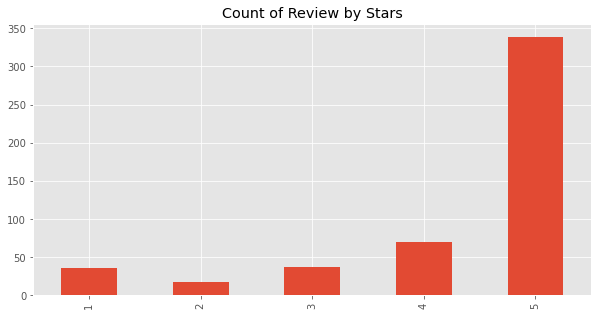

In [6]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of Review by Stars', figsize=(10,5))
ax.set_label('Review Scores')
plt.show()

Basic NLTK

In [7]:
example = df['Text'][0]
print(example)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [9]:
tokens = nltk.word_tokenize(example)
tokens[:10]


['I',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'Vitality',
 'canned',
 'dog',
 'food']

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('have', 'VBP'),
 ('bought', 'VBN'),
 ('several', 'JJ'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('Vitality', 'NNP'),
 ('canned', 'VBD'),
 ('dog', 'RP'),
 ('food', 'NN')]

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  have/VBP
  bought/VBN
  several/JJ
  of/IN
  the/DT
  (ORGANIZATION Vitality/NNP)
  canned/VBD
  dog/RP
  food/NN
  products/NNS
  and/CC
  have/VBP
  found/VBN
  them/PRP
  all/DT
  to/TO
  be/VB
  of/IN
  good/JJ
  quality/NN
  ./.
  The/DT
  product/NN
  looks/VBZ
  more/RBR
  like/IN
  a/DT
  stew/NN
  than/IN
  a/DT
  processed/JJ
  meat/NN
  and/CC
  it/PRP
  smells/VBZ
  better/RBR
  ./.
  My/PRP$
  (ORGANIZATION Labrador/NNP)
  is/VBZ
  finicky/JJ
  and/CC
  she/PRP
  appreciates/VBZ
  this/DT
  product/NN
  better/JJR
  than/IN
  most/JJS
  ./.)


# Step1. VADER Sentiment Scoring 
We will use SentimentIntensityAnalyzer to get the neg/new/pos scores of the text

-> This uses a "bag of words" approach
1. Stop words are removed 
2. Each words is scored and combined to a total score

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sim  = SentimentIntensityAnalyzer()

In [18]:
sim.polarity_scores('Iam so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [19]:
sim.polarity_scores("This is the worst thing ever")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [20]:
sim.polarity_scores(example)

{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [22]:
#Run the polarity score on entire dataset 
res = {}

for i, row in tqdm(df.iterrows(),total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sim.polarity_scores(text)
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

In [30]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [31]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

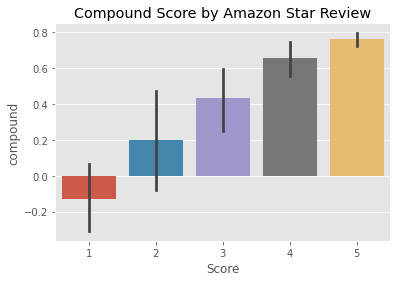

In [33]:
ax = sns.barplot(data= vaders, x ="Score", y ="compound")
ax.set_title('Compound Score by Amazon Star Review')
plt.show()


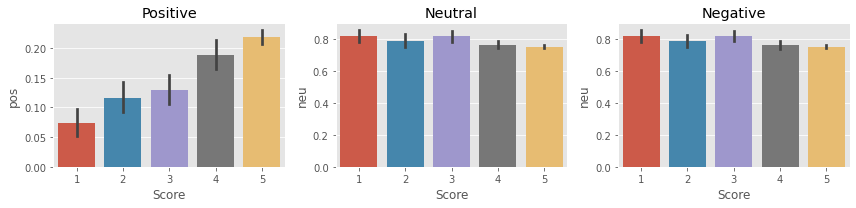

In [37]:
fig, axs = plt.subplots(1,3, figsize =(12,3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

1. Use a model trained a large of a large corpus of data
2. Transformer model accounts for the words but also the context related to other words

In [39]:
!pip install transformers

     ---------------------------------------- 7.9/7.9 MB 9.6 MB/s eta 0:00:00
     -------------------------------------- 311.7/311.7 kB 9.7 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 13.9 MB/s eta 0:00:00
     ------------------------------------- 277.2/277.2 kB 16.7 MB/s eta 0:00:00
     ---------------------------------------- 166.4/166.4 kB ? eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.10.1
    Uninstalling fsspec-2021.10.1:
      Successfully uninstalled fsspec-2021.10.1



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification 
from scipy.special import softmax

In [42]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [44]:
#VADER results on example
print(example)
sim.polarity_scores(example)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [50]:
#Run roberta model 
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict ={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [55]:
#Run the polarity score on entire dataset 
res = {}

for i, row in tqdm(df.iterrows(),total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sim.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename,**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [63]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

In [64]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Compare and combine between models 


In [62]:
results_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


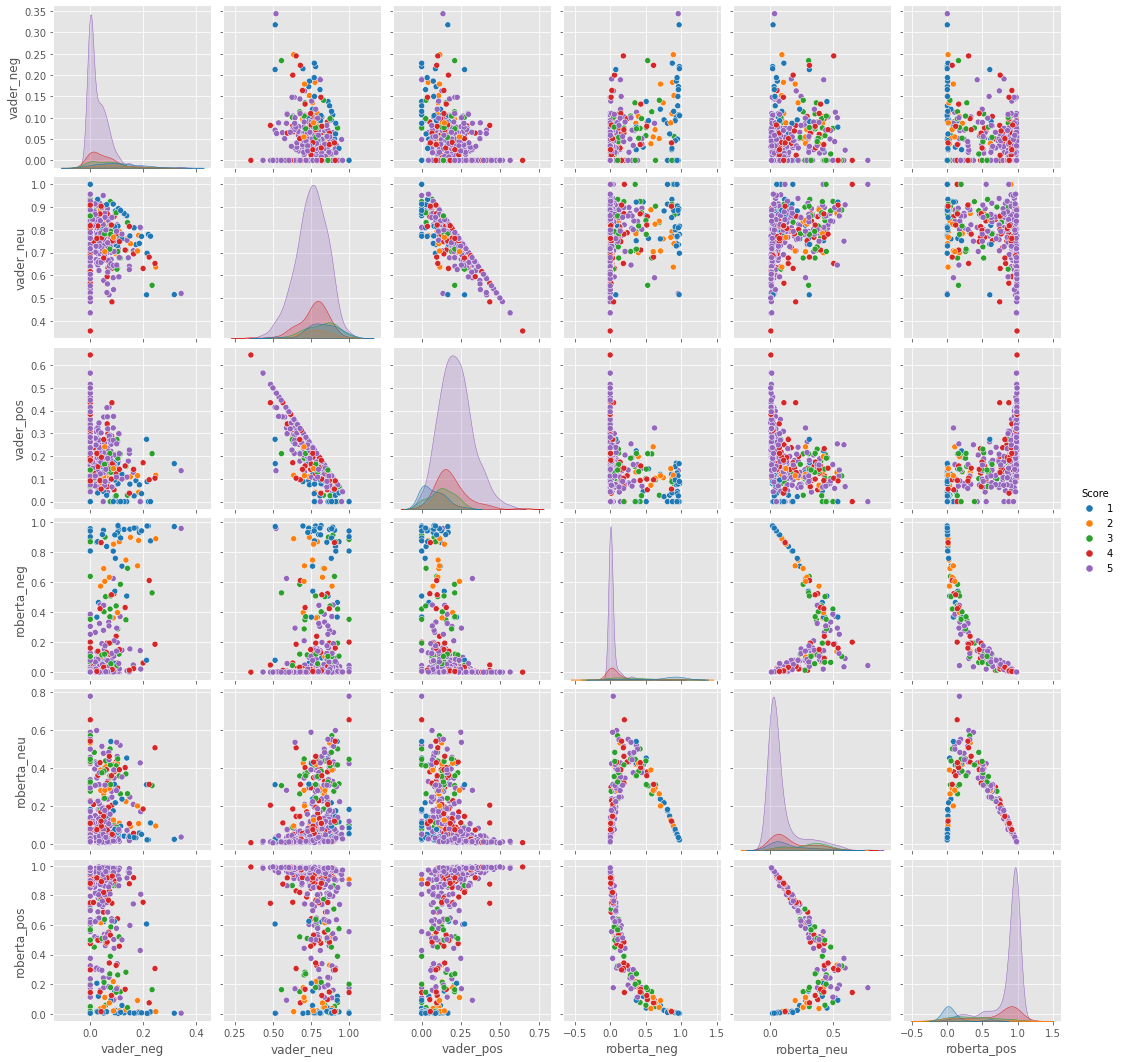

In [66]:
sns.pairplot(data = results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
        hue='Score',
        palette='tab10')

plt.show()

## Step 4. Review Examples 

1. Positive 1 -Star and Negative 5-Star Reviews



In [68]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [69]:
results_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [71]:
#Negative sentiment with 5 start review 
results_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [72]:
#Negative sentiment with 5 start review 
results_df.query('Score == 5').sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# The transformers pipeline

In [73]:
from transformers import pipeline 

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [76]:
sent_pipeline('This was a good project')

[{'label': 'POSITIVE', 'score': 0.9998643398284912}]

In [77]:
sent_pipeline('I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money')

[{'label': 'NEGATIVE', 'score': 0.9971690773963928}]